In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import plantcv as pcv
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)
import numpy as np

In [2]:
# image = "./LT1a/snapshot26828/VIS_SV_0_z1_h1_g0_e65_v500_57194_0.png"
# image = "./LT1a/snapshot2239/VIS_SV_0_z1_h1_g0_e65_v500_3092_0.png"
# image = "./LT1a/snapshot26899/VIS_SV_0_z1_h1_g0_e65_v500_57620_0.png"
# image = "./LT1a/snapshot26898/VIS_SV_0_z1_h1_g0_e65_v500_57611_0.png"
image = "./LT1a/snapshot26854/VIS_SV_0_z1_h1_g0_e65_v500_57350_0.png"
debug = "plot"
device = 0
writeimg = False
result_file = "test_results.txt"
coresult_file = "test_coresults.txt"

In [3]:
def crop_sides_equally(mask, nir, device, debug):
    device += 1
    # OpenCV refers to y first then x
    final_y = np.shape(mask)[0]
    final_x = np.shape(mask)[1]
    difference_x = final_x - np.shape(nir)[1]
    difference_y = final_y - np.shape(nir)[0]
    if difference_x % 2 == 0:
        x1 = difference_x / 2
        x2 = difference_x / 2
    else:
        x1 = difference_x / 2
        x2 = (difference_x / 2) + 1

    if difference_y % 2 == 0:
        y1 = difference_y / 2
        y2 = difference_y / 2
    else:
        y1 = difference_y / 2
        y2 = (difference_y / 2) + 1
    crop_img = mask[y1:final_y - y2, x1:final_x - x2]
    
    if debug == "print":
        pcv.print_image(crop_img, str(device) + "_crop_sides_equally.png")
    elif debug == "plot":
        pcv.plot_image(crop_img, cmap="gray")
    
    return(device, crop_img)

def conv_ratio(y = 606.0, x = 508.0, conv_x = 1.125, conv_y = 1.125, rat = 1):
    prop2 = (x / 2056)
    prop1 = (y / 2454)
    rat = 1
    conv_x = 1.125
    conv_y = 1.125
    prop2 = prop2 * (conv_y * rat)
    prop1 = prop1 * (conv_x * rat)
    return (prop2, prop1)

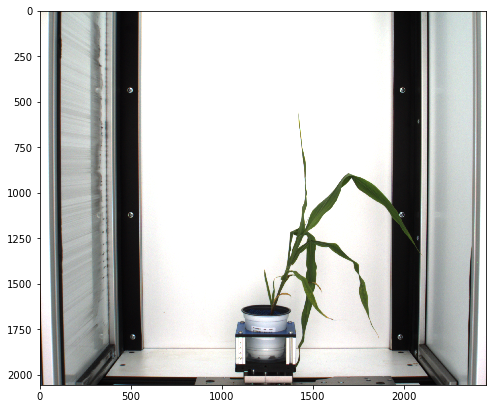

In [4]:
# Read image
img, path, filename = pcv.readimage(filename=image, debug=debug)

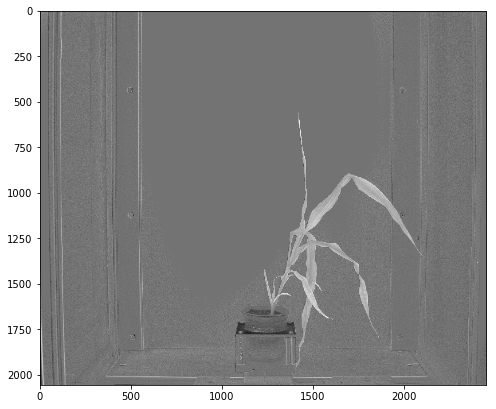

In [5]:
# Convert RGB to LAB and extract the Blue-Yellow channel
device, blue_channel = pcv.rgb2gray_lab(img=img, channel="b", device=device, debug=debug)

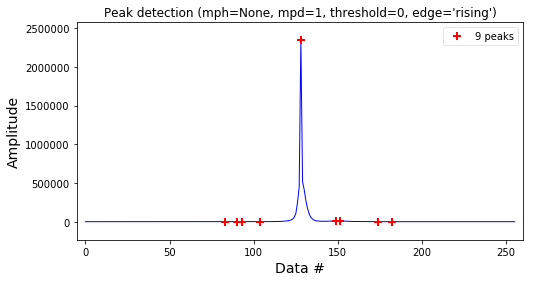

/Library/Python/2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Threshold value = 135


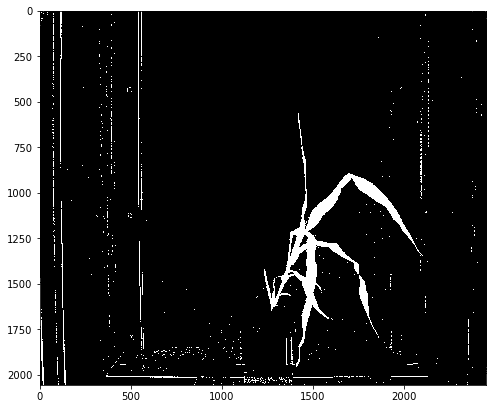

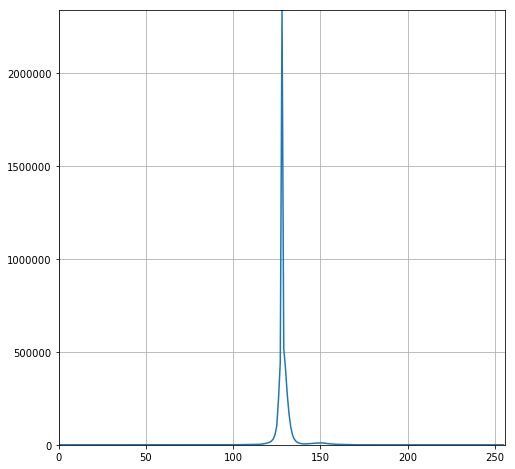

In [6]:
# Threshold the blue image using the triangle autothreshold method
device, blue_tri = pcv.triangle_auto_threshold(device=device, img=blue_channel, maxvalue=255, object_type="light", 
                                               xstep=1, debug=debug)

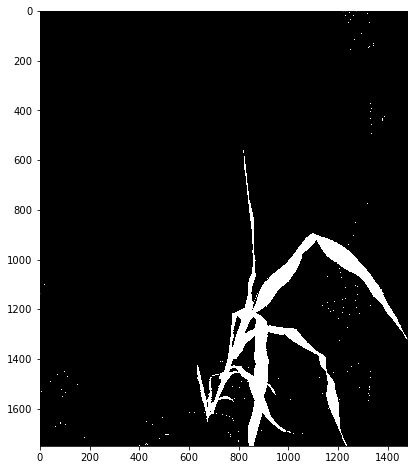

In [7]:
# Extract core plant region from the image to preserve delicate plant features during filtering
plant_region = blue_tri[0:1750, 600:2080]
plt.imshow(plant_region, cmap="gray")
plt.show()

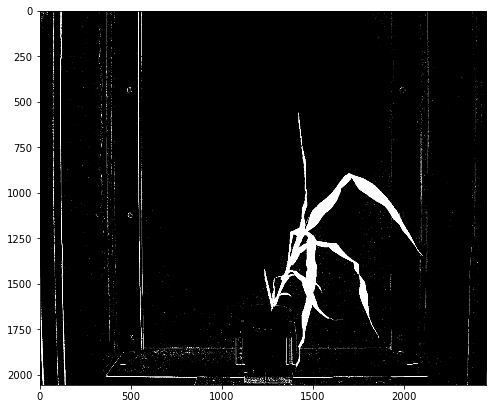

In [8]:
# Use a Gaussian blur to disrupt the strong edge features in the cabinet
device, blur_gaussian = pcv.gaussian_blur(device=device, img=blue_tri, ksize=(3, 3), 
                                          sigmax=0, sigmay=None, debug=debug)

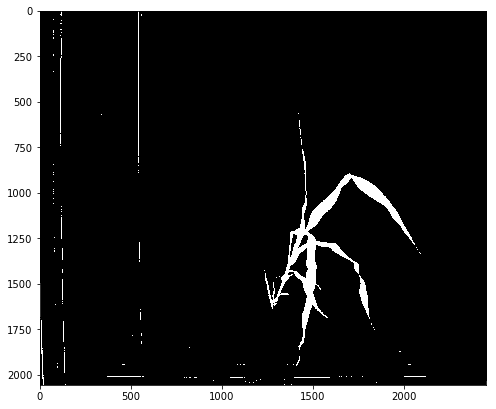

In [9]:
# Threshold the blurred image to remove features that were blurred
device, blur_thresholded = pcv.binary_threshold(img=blur_gaussian, threshold=250, maxValue=255, object_type="light", 
                                                device=device, debug=debug)

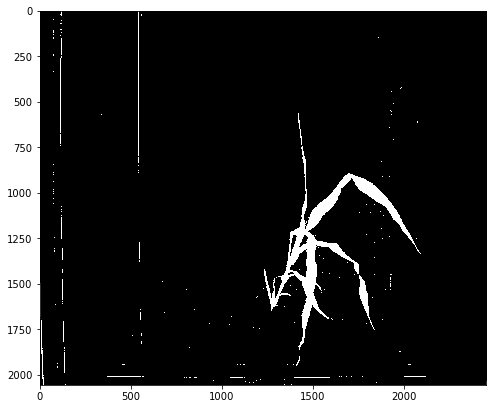

In [10]:
# Add the plant region back in to the filtered image
blur_thresholded[0:1750, 600:2080] = plant_region
plt.imshow(blur_thresholded, cmap="gray")
plt.show()

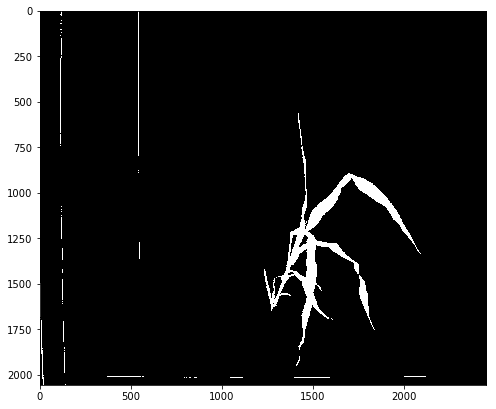

In [11]:
# Fill small noise
device, blue_fill_50 = pcv.fill(img=np.copy(blur_thresholded), mask=np.copy(blur_thresholded), size=50, 
                                 device=device, debug=debug)

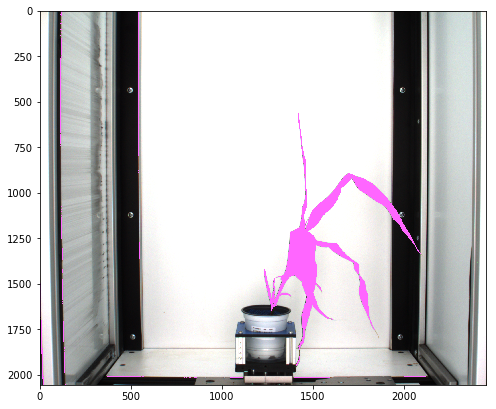

In [12]:
# Identify objects
device, contours, contour_hierarchy = pcv.find_objects(img=img, mask=blue_fill_50, device=device, debug=debug)

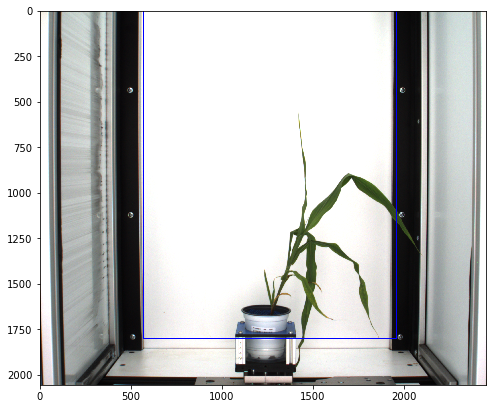

In [13]:
# Define ROI
device, roi, roi_hierarchy = pcv.define_roi(img=img, shape="rectangle", device=device, roi=None, roi_input="default",
                                            debug=debug, adjust=True, x_adj=565, y_adj=0, w_adj=-490, h_adj=-250)

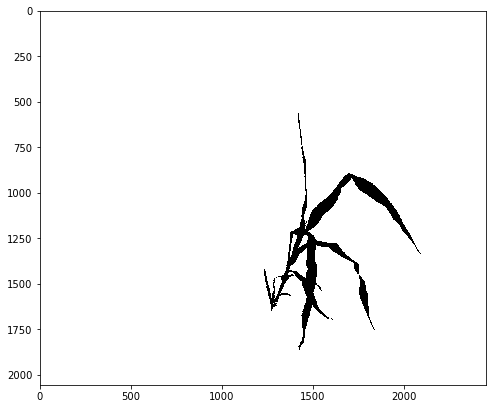

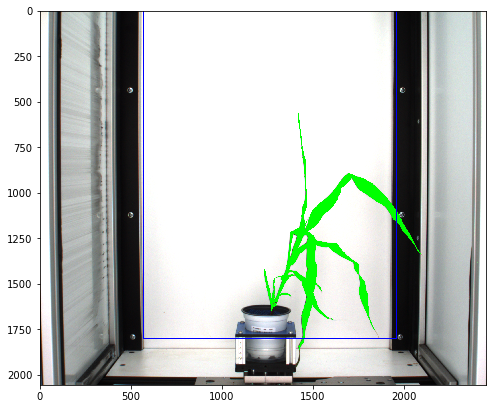

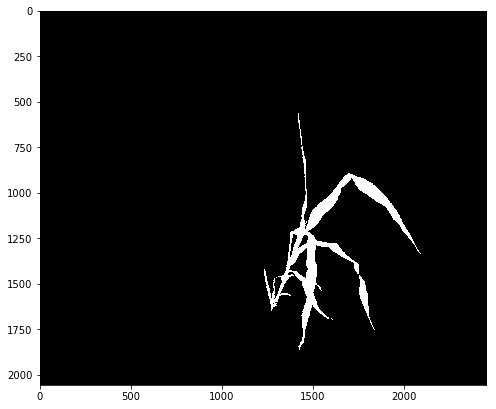

In [14]:
# Decide which objects to keep
device, roi_contours, roi_contour_hierarchy, roi_mask, roi_obj_area = pcv.roi_objects(img=img, roi_type="partial",
                                                                                      roi_contour=roi, 
                                                                                      roi_hierarchy=roi_hierarchy,
                                                                                      object_contour=contours, 
                                                                                      obj_hierarchy=contour_hierarchy,
                                                                                      device=device, debug=debug)

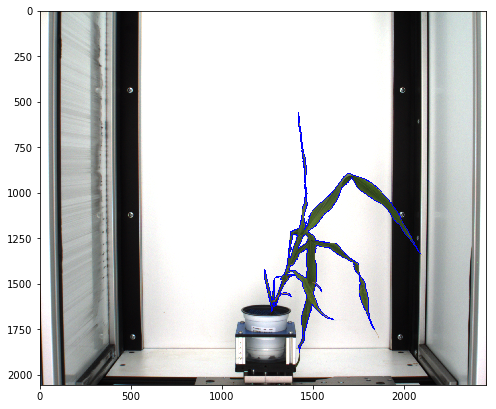

In [15]:
# Object combine kept objects
device, plant_contour, plant_mask = pcv.object_composition(img=img, contours=roi_contours, 
                                                           hierarchy=roi_contour_hierarchy, device=device, debug=debug)

In [16]:
outfile = False
if writeimg == True:
    outfile = args.outdir + "/" + filename

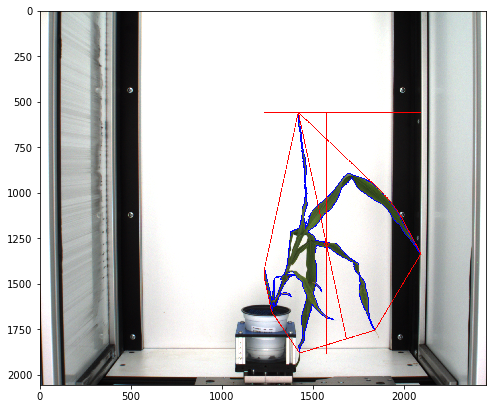

In [17]:
# Find shape properties, output shape image (optional)
device, shape_header, shape_data, shape_img = pcv.analyze_object(img=img, imgname=image, obj=plant_contour, 
                                                                 mask=plant_mask, device=device, debug=debug, 
                                                                 filename=outfile)

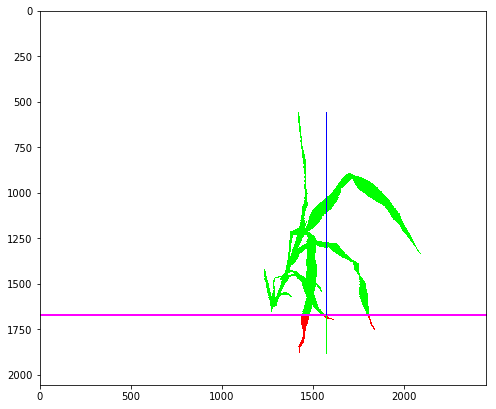

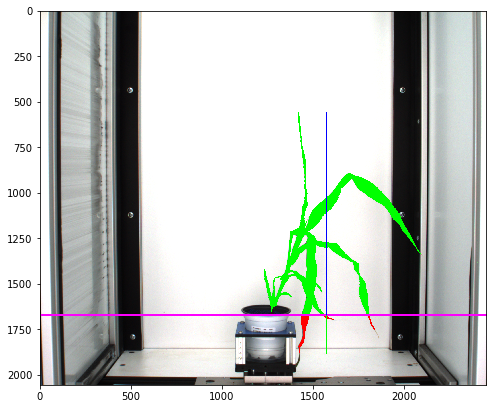

In [18]:
# Shape properties relative to user boundary line (optional)
device, boundary_header, boundary_data, boundary_img = pcv.analyze_bound(img=img, imgname=image, obj=plant_contour, 
                                                                         mask=plant_mask, line_position=380, 
                                                                         device=device, debug=debug, filename=outfile)

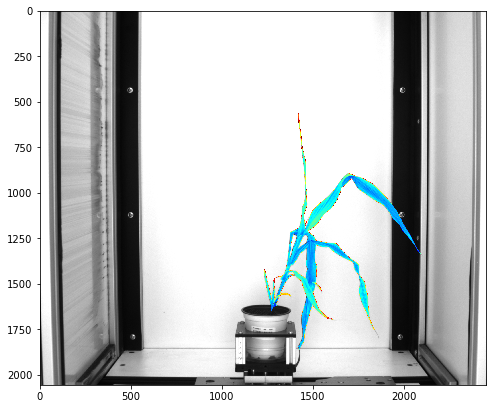

In [19]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, 
# output color analyzed images (optional)
device, color_header, color_data, color_img = pcv.analyze_color(img=img, imgname=image, mask=plant_mask, bins=256, 
                                                                device=device, debug=debug, hist_plot_type=None, 
                                                                pseudo_channel="v", pseudo_bkg="img", resolution=300, 
                                                                filename=outfile)

In [20]:
# Output shape and color data
result = open(result_file, "a")
result.write('\t'.join(map(str, shape_header)) + "\n")
result.write('\t'.join(map(str, shape_data)) + "\n")
for row in shape_img:
    result.write('\t'.join(map(str, row)) + "\n")
result.write('\t'.join(map(str, color_header)) + "\n")
result.write('\t'.join(map(str, color_data)) + "\n")
result.write('\t'.join(map(str, boundary_header)) + "\n")
result.write('\t'.join(map(str, boundary_data)) + "\n")
result.write('\t'.join(map(str, boundary_img)) + "\n")
for row in color_img:
    result.write('\t'.join(map(str, row)) + "\n")
result.close()

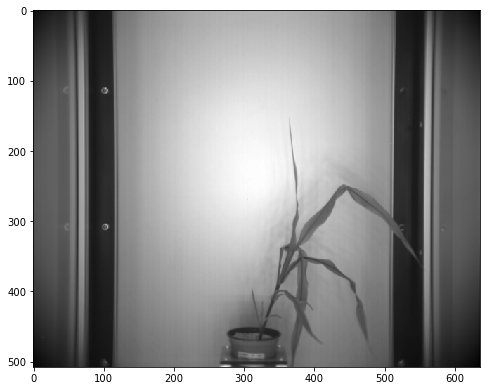

In [21]:
# Find matching NIR image
device, nirpath = pcv.get_nir(path=path, filename=filename, device=device, debug=debug)
nir_rgb, nir_path, nir_filename = pcv.readimage(nirpath)
nir_img = cv2.imread(nirpath, 0)
plt.imshow(nir_img, cmap="gray")
plt.show()

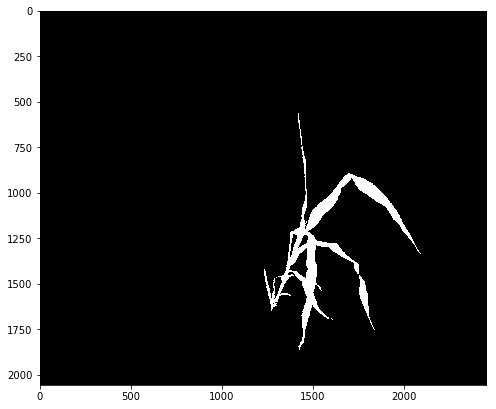

In [22]:
# Make mask glovelike in proportions via dilation
device, d_mask = pcv.dilate(plant_mask, kernel=1, i=0, device=device, debug=debug)

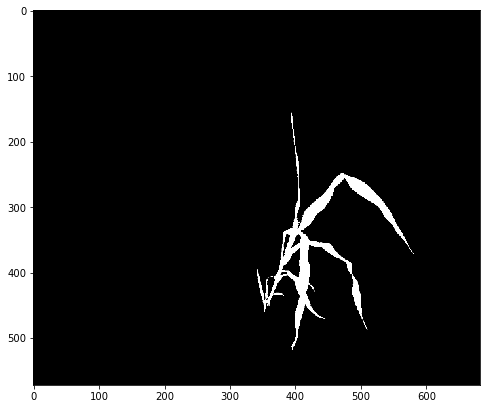

In [23]:
# Resize mask
prop2, prop1 = conv_ratio()
device, nmask = pcv.resize(img=d_mask, resize_x=prop1, resize_y=prop2, device=device, debug=debug)

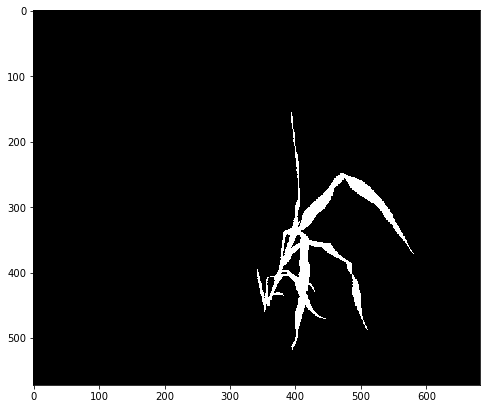

In [24]:
# Convert the resized mask to a binary mask
device, bmask = pcv.binary_threshold(img=nmask, threshold=0, maxValue=255, object_type="light", 
                                     device=device, debug=debug)

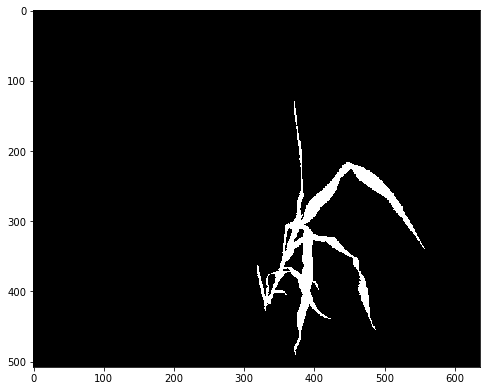

In [25]:
device, crop_img = crop_sides_equally(mask=bmask, nir=nir_img, device=device, debug=debug)

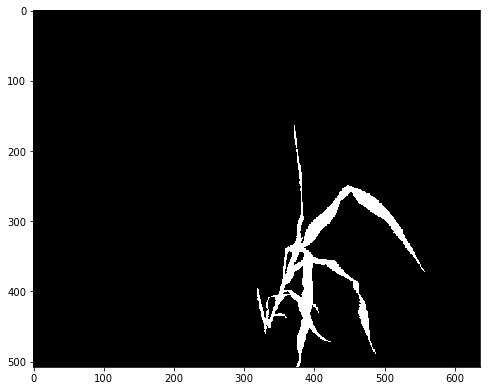

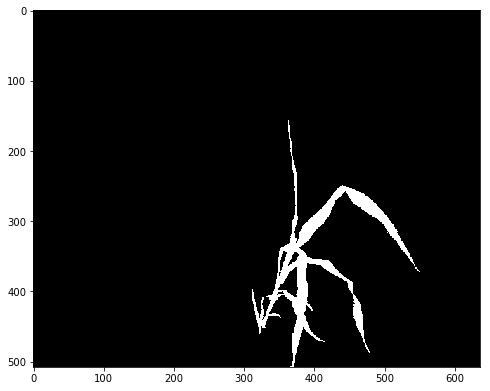

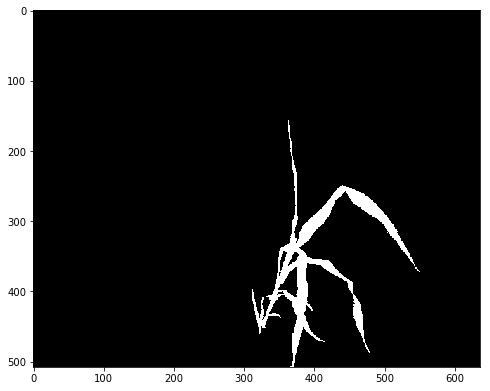

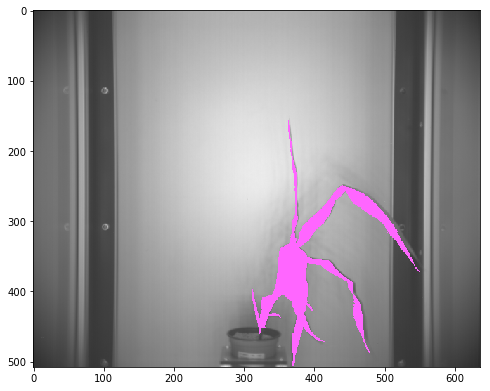

In [26]:
# position, and crop mask
device, newmask = pcv.crop_position_mask(img=nir_img, mask=crop_img, device=device, x=34, y=9, v_pos="top", 
                                         h_pos="right", debug=debug)

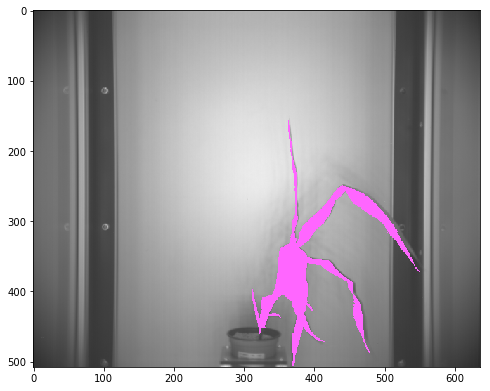

In [27]:
# Identify objects
device, nir_objects, nir_hierarchy = pcv.find_objects(img=nir_rgb, mask=newmask, device=device, debug=debug)

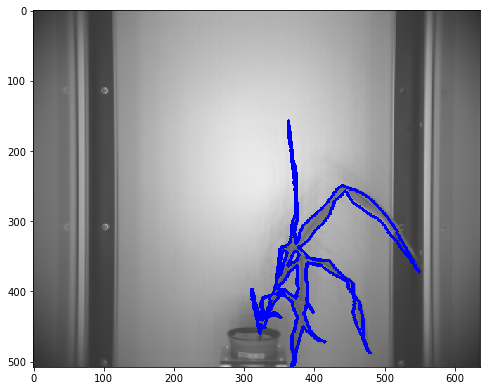

In [28]:
# Object combine kept objects
device, nir_combined, nir_combinedmask = pcv.object_composition(img=nir_rgb, contours=nir_objects, 
                                                                hierarchy=nir_hierarchy, device=device, debug=debug)

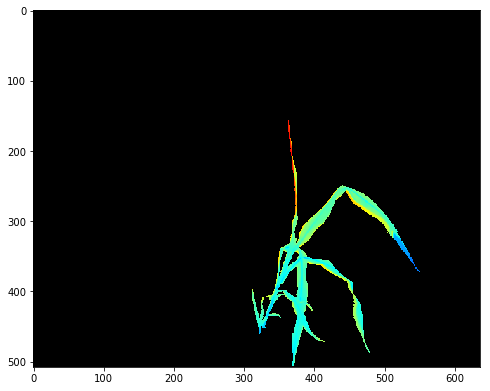

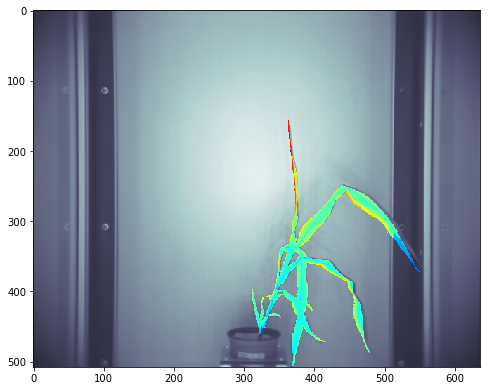

In [29]:
# Analyze NIR signal data
device, nhist_header, nhist_data, nir_imgs = pcv.analyze_NIR_intensity(img=nir_img, rgbimg=nir_rgb, 
                                                                       mask=nir_combinedmask, bins=256, device=device, 
                                                                       histplot=False, debug=debug, filename=outfile)

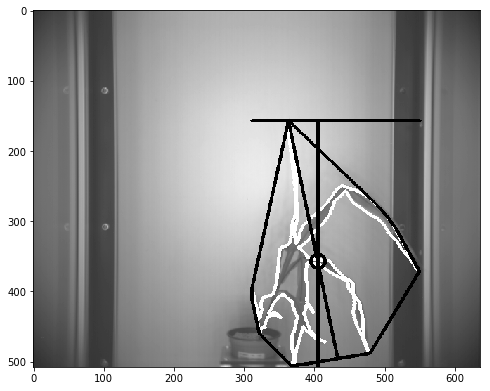

In [30]:
# Analyze the shape of the plant contour from the NIR image
device, nshape_header, nshape_data, nir_shape = pcv.analyze_object(img=nir_img, imgname=nir_filename, obj=nir_combined,
                                                                   mask=nir_combinedmask, device=device, debug=debug, 
                                                                   filename=outfile)

In [31]:
# Write NIR data to co-results file
coresult = open(coresult_file, "a")
coresult.write('\t'.join(map(str, nhist_header)) + "\n")
coresult.write('\t'.join(map(str, nhist_data)) + "\n")
for row in nir_imgs:
    coresult.write('\t'.join(map(str, row)) + "\n")
coresult.write('\t'.join(map(str, nshape_header)) + "\n")
coresult.write('\t'.join(map(str, nshape_data)) + "\n")
coresult.write('\t'.join(map(str, nir_shape)) + "\n")
coresult.close()